# Chargement des données


In [147]:
!git clone https://github.com/Romain-Malinge/Deep_learning_groupe_A.git
path = "./Deep_learning_groupe_A/BD/"

fatal: destination path 'Deep_learning_groupe_A' already exists and is not an empty directory.


Une fois les données téléchargées localement, on peut maintenant charger les images et les labels. Si vous avez construit votre arborescence de la même manière que la mienne, et que vous adaptez les noms de labels à votre projet, alors le code suivant devrait être utilisable directement.

In [148]:
import os
import shutil

import numpy as np
import PIL
from PIL import Image
import os, sys
from scipy.io import loadmat


def load_data(data_path, classes, dataset, row, col):

    num_images = 0
    for i in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[i]))
        num_images += len(dirs)

    x = np.zeros((num_images, row, col, 3))
    y = np.zeros((num_images, 4))

    current_index = 0

    # Parcours des différents répertoires pour collecter les images
    for idx_class in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[idx_class]))
        num_images += len(dirs)

        # Chargement des images,
        for idx_img in range(len(dirs)):
            item = dirs[idx_img]
            if os.path.isfile(data_path + dataset + '/' + classes[idx_class] + '/' + item):
                # Ouverture de l'image
                img = Image.open(data_path + dataset + '/' + classes[idx_class] + '/' + item)
                # Conversion de l'image en RGB
                img = img.convert('RGB')
                # Redimensionnement de l'image et écriture dans la variable de retour x
                img = img.resize((col, row))
                x[current_index] = np.asarray(img)
                # Écriture du label associé dans la variable de retour y
                y[current_index][idx_class] = 1
                current_index += 1

    return x, y

Voici ensuite un exemple de chargement de vos données. Notez que vous pouvez modifier la dimension des images, ce qui sera utile à différents stades de votre projet.

In [149]:
row = 192 // 2
col = 256 // 2

labels = ['1', '2', '3', '4']

x_train, y_train = load_data(path, labels, 'entrainement', row, col)
print(x_train.shape, y_train.shape)

x_val, y_val = load_data(path, labels, 'validation', row, col)
print(x_val.shape, y_val.shape)

x_test, y_test = load_data(path, labels, 'test', row, col)
print(x_test.shape, y_test.shape)

(4000, 96, 128, 3) (4000, 4)
(1000, 96, 128, 3) (1000, 4)
(100, 96, 128, 3) (100, 4)


Vous pouvez utiliser le bloc suivant pour afficher quelques-unes de vos images, et ainsi vérifier que tout s'est bien passé.

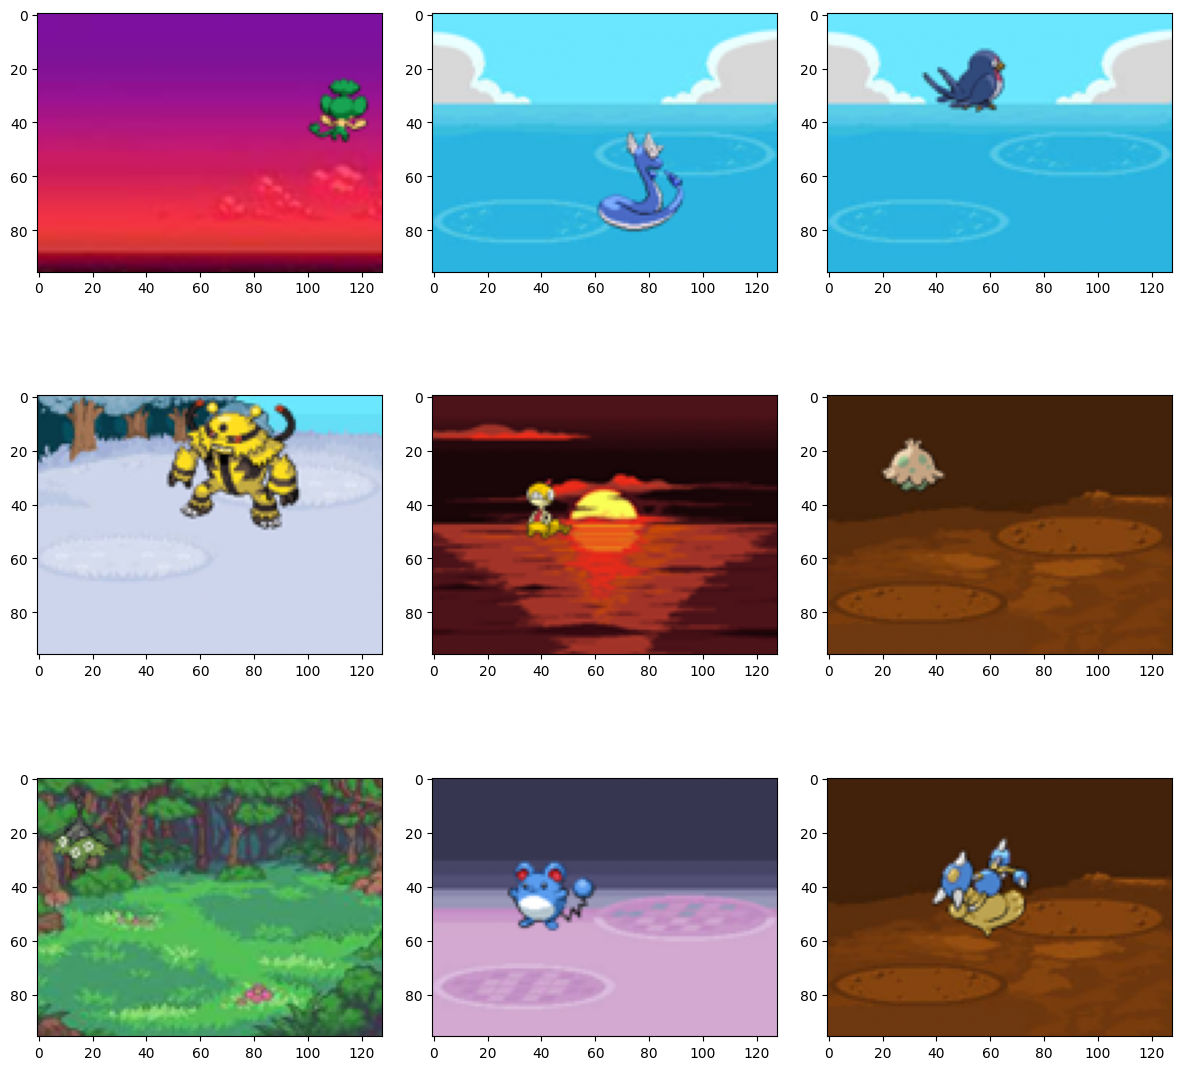

In [150]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
shuffle_indices = np.random.permutation(9)
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    image = x_train[shuffle_indices[i]]
    #plt.title(labels[int(y_train[shuffle_indices[i]])])
    plt.imshow(image/255)

plt.tight_layout()
plt.show()

#  Création de notre réseau de neurones

In [151]:
def plot_training_analysis():
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

Dans un premier temps nous allons utiliser un réseau basique et voir les résultats.

In [152]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers

input_shape = (row, col, 3)

model = Sequential()

model.add(Conv2D(96,3,activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128,3,activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(192,3,activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256,3,activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256,1,activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(2048, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))

model.add(Dense(4, activation='softmax'))

In [153]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 94, 126, 96)       2688      
                                                                 
 max_pooling2d_60 (MaxPooli  (None, 47, 63, 96)        0         
 ng2D)                                                           
                                                                 
 conv2d_61 (Conv2D)          (None, 45, 61, 128)       110720    
                                                                 
 max_pooling2d_61 (MaxPooli  (None, 22, 30, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_62 (Conv2D)          (None, 20, 28, 192)       221376    
                                                                 
 max_pooling2d_62 (MaxPooli  (None, 10, 14, 192)     

In [154]:
from tensorflow.keras import optimizers

# Fonction cout
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-3),
              metrics=['accuracy'])

In [155]:
from tensorflow.keras.callbacks import ModelCheckpoint

# On prend les meilleurs valeurs
checkpoint_filepath = path +"/bestPoint"
model_checkpoint_callback = ModelCheckpoint(
    filepath= checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [156]:
# Analyse de notre modèle
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, callbacks=[model_checkpoint_callback])

Epoch 1/100
125/125 [==============================] - 9s 51ms/step - loss: 5.4302 - accuracy: 0.2697 - val_loss: 0.8137 - val_accuracy: 0.3770
Epoch 2/100
125/125 [==============================] - 6s 49ms/step - loss: 0.7763 - accuracy: 0.3787 - val_loss: 0.7183 - val_accuracy: 0.4290
Epoch 3/100
125/125 [==============================] - 6s 45ms/step - loss: 0.7252 - accuracy: 0.4190 - val_loss: 0.6753 - val_accuracy: 0.4740
Epoch 4/100
125/125 [==============================] - 6s 49ms/step - loss: 0.6683 - accuracy: 0.4518 - val_loss: 0.6069 - val_accuracy: 0.5180
Epoch 5/100
125/125 [==============================] - 4s 33ms/step - loss: 0.6259 - accuracy: 0.5038 - val_loss: 0.6077 - val_accuracy: 0.5030
Epoch 6/100
125/125 [==============================] - 7s 54ms/step - loss: 0.6034 - accuracy: 0.5182 - val_loss: 0.5642 - val_accuracy: 0.5720
Epoch 7/100
125/125 [==============================] - 4s 33ms/step - loss: 0.5750 - accuracy: 0.5495 - val_loss: 0.5751 - val_accuracy:

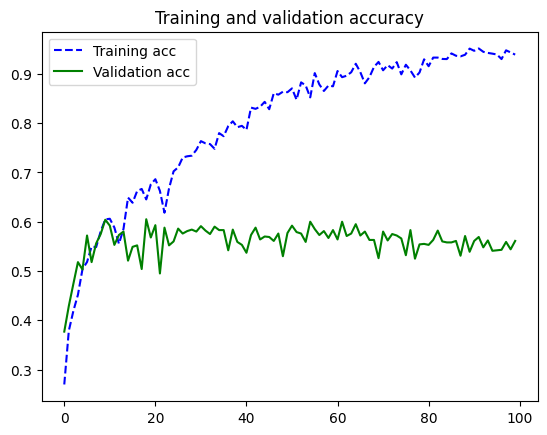

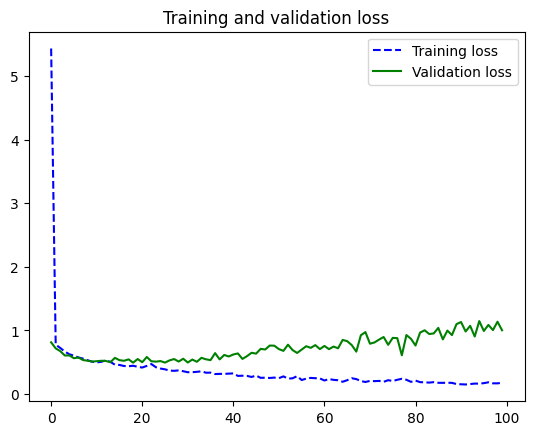

In [157]:
# Affichage du training
plot_training_analysis()

Pour les données de test, il faudra utiliser un evaluate.
Le code suivant ne fonctionne pas.


In [158]:
# Résultat avec les tests
last_result = model.evaluate(x_test, y_test, batch_size=32)
model.load_weights(checkpoint_filepath)
best_result = model.evaluate(x_test, y_test, batch_size=32)

4/4 [==============================] - 0s 13ms/step - loss: 0.8189 - accuracy: 0.4800
